# Individual glacier data inspection

This notebook will walk through steps to read in and organize velocity data and clip it to the extent of a single glacier. The tools we will use include **xarray**, **rioxarray**, **geopandas**, and **flox**. 

To clip its_live data to the extent of a single glacier we will use a vector dataset of glacier outlines, the [Randolph Glacier Inventory](https://nsidc.org/data/nsidc-0770). These aren't cloud-hosted currently so you will need to download the data to your local machine. 

**Learning goals**
come back and finish these, feel like this notebook has alot, is pretty disorganized.. </br>
- subset large raster to spatial area of interest
- exploring with **dask** and **xarray**
- dataset inspection using
    - xarray label and index-based selections
    - grouped computations and reductions
    - visualization

First, lets install the python libraries that we'll need for this notebook:

In [1]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from shapely.geometry import Polygon
from shapely.geometry import Point
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import cartopy.feature as cfeature
import json
import urllib.request
import pandas as pd
import flox
%config InlineBackend.figure_format='retina'


## Reading in ITS_LIVE data

We will use some of the functions we defined in the data access notebook in this notebook and others within this tutorial. They will all be within the `itslivetools` package.

In [2]:
import itslivetools

First, let's read in the catalog again:  

In [3]:
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url_catalog:
    itslive_catalog = json.loads(url_catalog.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

The `read_in_s3()` function will read in a xarray dataset from a url to a zarr datacube when we're ready:

I started with `chunk_size='auto'` which will choose chunk sizes that match the underlying data structure (this is generally ideal). More about choosing good chunk sizes [here](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes). If you want to use a different chunk size, specify it when you call the `read_in_s3()` function.

In [4]:
url = itslivetools.find_granule_by_point(itslive_catalog, [84.56, 28.54])
url

['http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3150000.zarr']

In [5]:
dc = itslivetools.read_in_s3(url[0])
dc

<xarray.Dataset>
Dimensions:                    (mid_date: 20549, y: 833, x: 833)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2020-02-07T17:10:52....
  * x                          (x) float64 2.001e+05 2.002e+05 ... 2.999e+05
  * y                          (y) float64 3.2e+06 3.2e+06 ... 3.1e+06 3.1e+06
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(20549,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

We are reading this in as a dask array. Let's take a look at the chunk sizes:

```{note} 
chunksizes shows the largest chunk size. chunks shows the sizes of all chunks along all dims, better if you have irregular chunks
```

In [ ]:
dc.chunksizes

In [ ]:
dc.chunks

```{note} 
Setting the dask chunksize to `auto` at the `xr.open_dataset()` step will use chunk sizes that most closely resemble the structure of the underlying data. To avoid imposing a chunk size that isn't a good fit for the data, avoid re-chunking until we have selected a subset of our area of interest from the larger dataset 
```

Check CRS of xr object: 

In [ ]:
dc.mapping

Let's take a look at the time dimension (`mid_date` here). To start with we'll just print the first 10 values:

In [ ]:
for element in range(10):
    
    print(dc.mid_date[element].data)

Weird, it doesn't look like the time dimension is in chronological order, let's fix that: 

In [7]:
dc_timesorted = dc.sortby(dc['mid_date'])
dc_timesorted

/Users/emarshall/miniconda3/envs/itslivetools_env/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/emarshall/miniconda3/envs/itslivetools_env/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[in

<xarray.Dataset>
Dimensions:                    (mid_date: 20549, y: 833, x: 833)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2013-04-09T16:49:00....
  * x                          (x) float64 2.001e+05 2.002e+05 ... 2.999e+05
  * y                          (y) float64 3.2e+06 3.2e+06 ... 3.1e+06 3.1e+06
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(20549,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

When we read in the zarr datacube as a `xr.Dataset` we set the chunk sizes to `auto`. When we try to sort along the `mid_date` dimension this seems to become a problem and we get the warning above. 

At first it makes sense to follow the instructions in the warning message to avoid creating large chunks, but this creates some issues. If you want, turn the cell below to `code` and run it, you can see that this re-chunks the time dimension which isn't something that we want 

import dask
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dc_timesorted_false = dc.sortby(dc['mid_date'])
    dc_timesorted_false

In [8]:
dc_timesorted

<xarray.Dataset>
Dimensions:                    (mid_date: 20549, y: 833, x: 833)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2013-04-09T16:49:00....
  * x                          (x) float64 2.001e+05 2.002e+05 ... 2.999e+05
  * y                          (y) float64 3.2e+06 3.2e+06 ... 3.1e+06 3.1e+06
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(20549,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(20549, 40, 40), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [9]:
for element in range(10):
    
    print(dc_timesorted.mid_date[element].data)

2013-04-09T16:49:00.528084992
2013-04-23T04:55:55.528083968
2013-04-25T16:49:09.528084992
2013-05-01T04:56:02.028083968
2013-05-03T16:49:08.028084992
2013-05-09T04:56:00.528083968
2013-05-09T04:56:03.528083968
2013-05-10T04:49:51.028084992
2013-05-17T04:56:02.028083968
2013-05-18T04:49:49.528084992


## Read in vector data 

We are going to read in RGI region **15 (SouthAsiaEast)**. RGI data is downloaded in lat/lon coordinates. We will project it to match the CRS of the ITS_LIVE dataset and then select an individual glacier to begin our analysis.

In [10]:
se_asia = gpd.read_file('/Users/emarshall/Desktop/siparcs/data/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp')
se_asia.head(3)

RGIId         GLIMSId   BgnDate   EndDate      CenLon     CenLat  \
0  RGI60-15.00001  G102044E29941N  19990920  -9999999  102.044042  29.941000   
1  RGI60-15.00002  G102042E29987N  19990920  -9999999  102.042346  29.987019   
2  RGI60-15.00003  G102041E29997N  19990920  -9999999  102.041130  29.997311   

  O1Region O2Region   Area  Zmin  ...  Aspect  Lmax  Status  Connect  Form  \
0       15        3  0.438  4996  ...     251   850       0        0     0   
1       15        3  0.644  4947  ...     244  1021       0        0     0   
2       15        3  0.225  5019  ...     274   812       0        0     0   

   TermType  Surging  Linkages  Name  \
0         0        9         9  None   
1         0        9         9  None   
2         0        9         9  None   

                                            geometry  
0  POLYGON ((102.03759 29.93828, 102.03759 29.938...  
1  POLYGON ((102.04195 29.99030, 102.04197 29.990...  
2  POLYGON ((102.03710 29.99774, 102.03719 29.998...  

[3 rows x 23 columns]

In [12]:
#project rgi data to match itslive
#we know the epsg from looking at the 'spatial epsg' attr of the mapping var of the dc object
se_asia_prj = se_asia.to_crs('EPSG:32645') 
se_asia_prj.head(3)

RGIId         GLIMSId   BgnDate   EndDate      CenLon     CenLat  \
0  RGI60-15.00001  G102044E29941N  19990920  -9999999  102.044042  29.941000   
1  RGI60-15.00002  G102042E29987N  19990920  -9999999  102.042346  29.987019   
2  RGI60-15.00003  G102041E29997N  19990920  -9999999  102.041130  29.997311   

  O1Region O2Region   Area  Zmin  ...  Aspect  Lmax  Status  Connect  Form  \
0       15        3  0.438  4996  ...     251   850       0        0     0   
1       15        3  0.644  4947  ...     244  1021       0        0     0   
2       15        3  0.225  5019  ...     274   812       0        0     0   

   TermType  Surging  Linkages  Name  \
0         0        9         9  None   
1         0        9         9  None   
2         0        9         9  None   

                                            geometry  
0  POLYGON ((1959630.570 3408951.748, 1959630.394...  
1  POLYGON ((1959271.126 3414873.173, 1959273.308...  
2  POLYGON ((1958682.136 3415647.929, 1958684.710...  

[3 rows x 23 columns]

## Crop RGI to ITS_LIVE extent
- is there a way to call `get_bbox_single()` without the plot output?

0    POLYGON ((83.95080 27.99167, 84.96524 28.01044...
Name: geometry, dtype: geometry

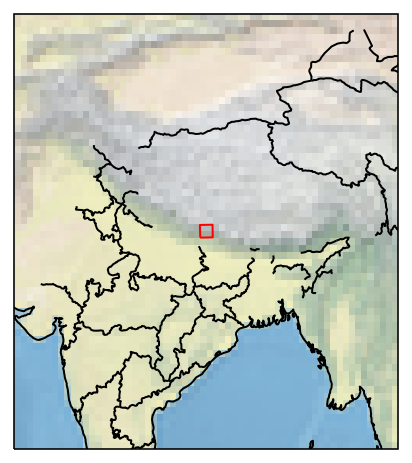

In [14]:
#first, get vector bbox of itslive

bbox_dc = itslivetools.get_bbox_single(dc)
bbox_dc['geometry']

In [15]:
#project from latlon to local utm 
bbox_dc = bbox_dc.to_crs('EPSG:32645')
bbox_dc

geometry
0  POLYGON ((200092.500 3100027.500, 299932.500 3...

In [16]:
#subset rgi to bounds 
se_asia_subset = gpd.clip(se_asia_prj, bbox_dc)
se_asia_subset
se_asia_subset.explore()

In [17]:
sample_glacier_vec = se_asia_subset.loc[se_asia_subset['RGIId'] == 'RGI60-15.04714']
sample_glacier_vec

RGIId         GLIMSId   BgnDate   EndDate     CenLon  \
4713  RGI60-15.04714  G084393E28743N  20010929  -9999999  84.392609   

         CenLat O1Region O2Region    Area  Zmin  ...  Aspect   Lmax  Status  \
4713  28.743019       15        1  13.593  4481  ...     317  12292       0   

      Connect  Form  TermType  Surging  Linkages  Name  \
4713        0     0         0        9         9  None   

                                               geometry  
4713  POLYGON ((242056.441 3181919.463, 242008.653 3...  

[1 rows x 23 columns]

### Clip ITS_LIVE dataset to individual glacier extent

First, we need to use rio.write_crs() to assign a CRS to the itslive object. If we don't do that first the `rio.clip()` command will produce an error
*Note*: it looks like you can only run write_crs() once, because it switches mapping from being a `data_var` to a `coord` so if you run it again it will produce a key error looking for a var that doesnt' exist

In [18]:
dc_timesorted = dc_timesorted.rio.write_crs(f"epsg:{dc_timesorted.mapping.attrs['spatial_epsg']}", inplace=True)

In [19]:
%%time

sample_glacier_raster = dc_timesorted.rio.clip(sample_glacier_vec.geometry, sample_glacier_vec.crs)

CPU times: user 435 ms, sys: 12.2 ms, total: 448 ms
Wall time: 448 ms


Take a look at the clipped object:

In [20]:
sample_glacier_raster

<xarray.Dataset>
Dimensions:                    (mid_date: 20549, y: 54, x: 100)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2013-04-09T16:49:00....
  * y                          (y) float64 3.188e+06 3.188e+06 ... 3.182e+06
  * x                          (x) float64 2.36e+05 2.361e+05 ... 2.479e+05
Data variables: (12/53)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(20549,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(20549, 20, 21), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(20549, 20, 21), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(20549,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(20549,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Let's take a look at the clipped raster alongside the vector outline. To start with and for the sake of easy visualizing we will take the mean of the magnitude of velocity variable along the `mid_date` dimension:

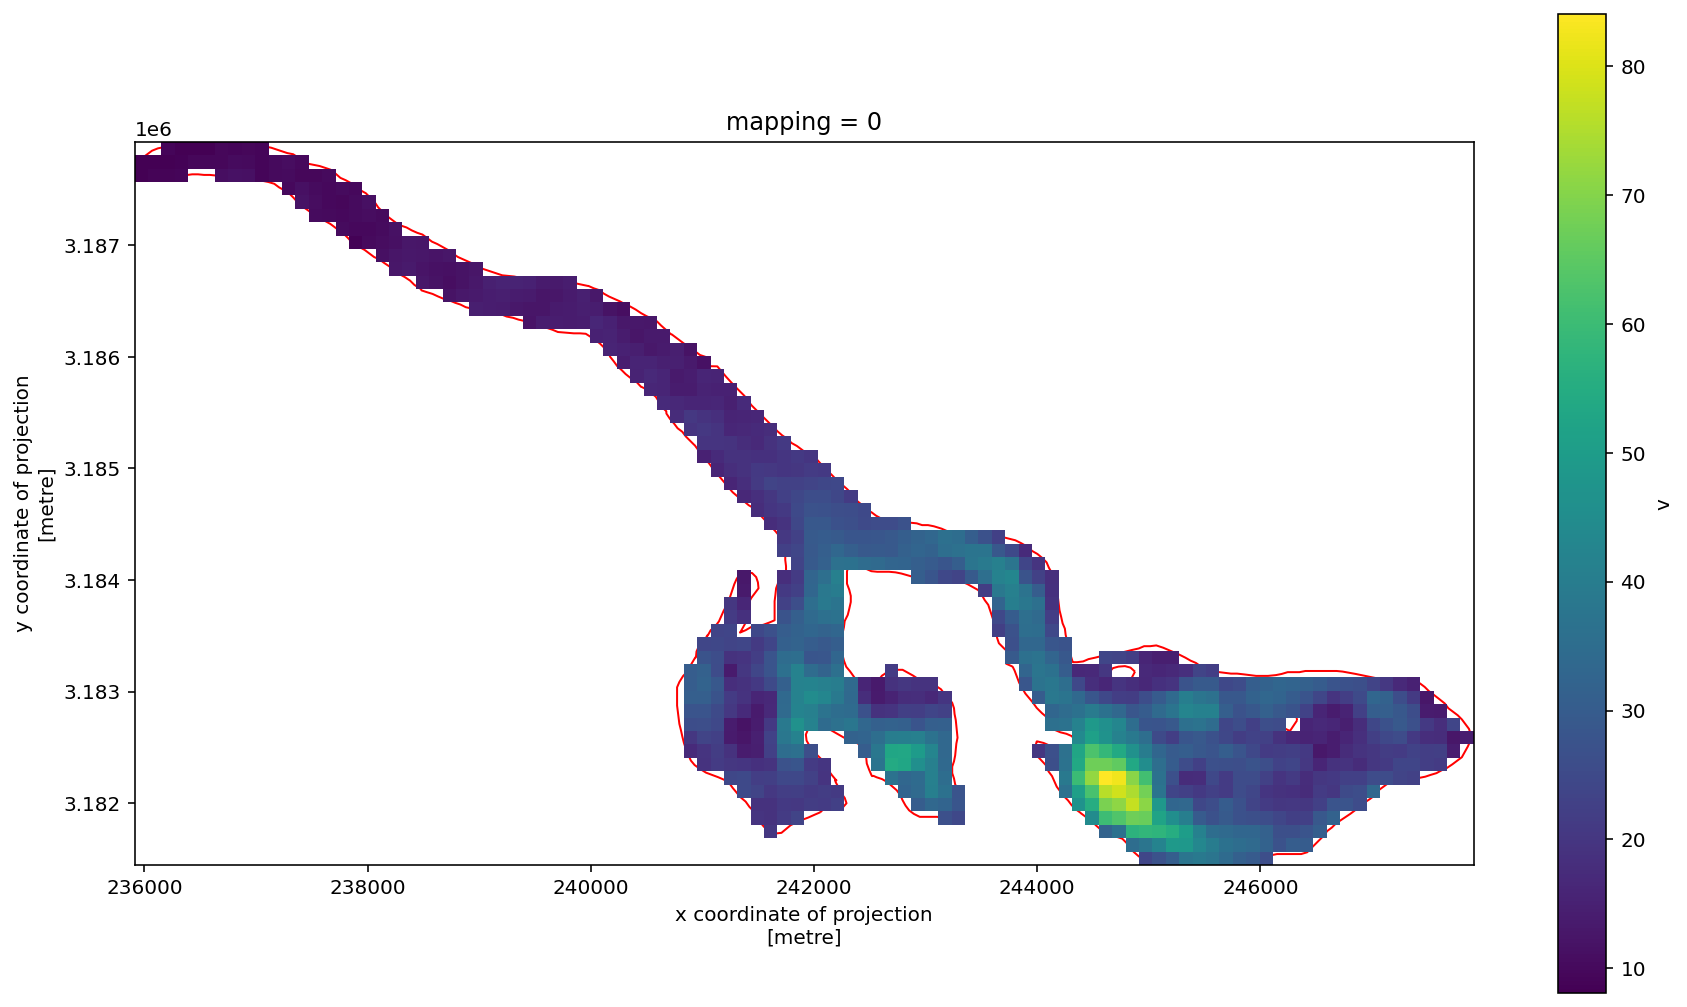

In [21]:
fig, ax = plt.subplots(figsize = (15,9))
sample_glacier_vec.plot(ax=ax, facecolor='none', edgecolor='red');
sample_glacier_raster.v.mean(dim=['mid_date']).plot(ax=ax);



Now let's take a look at the x and y components of velocity, again averaging over time:

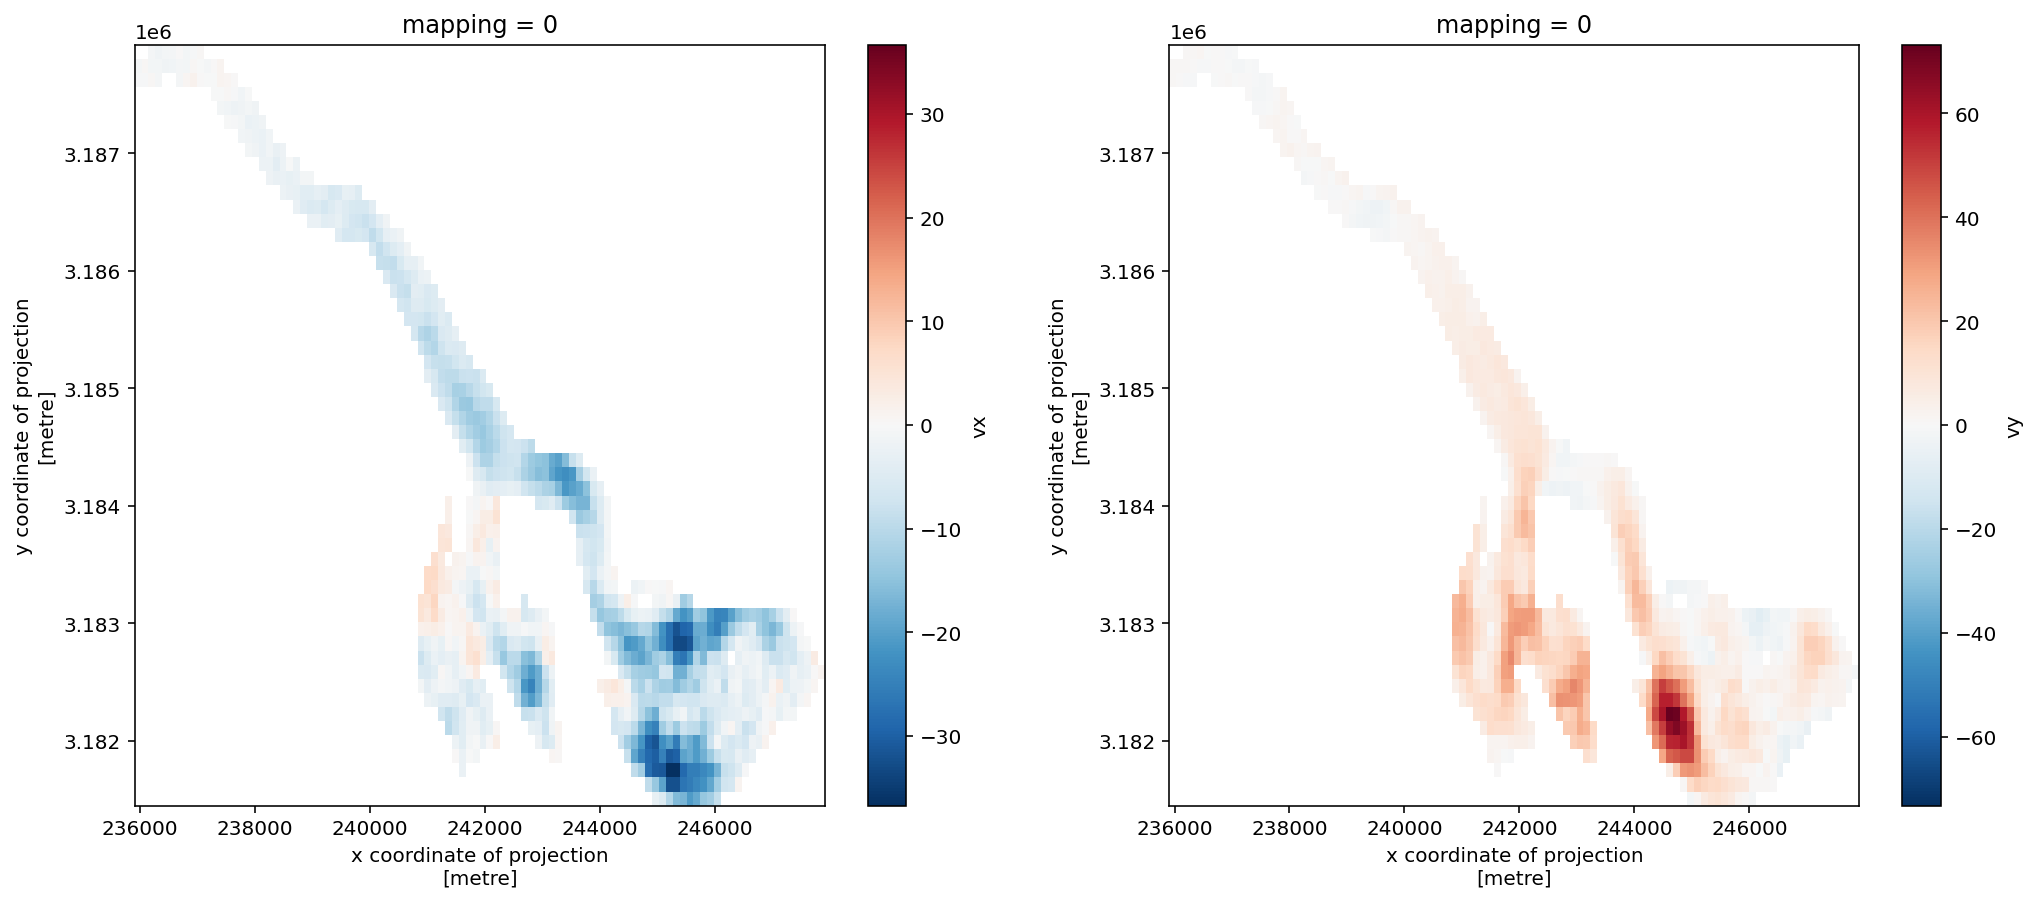

In [22]:
fig, axs = plt.subplots(ncols =2, figsize=(17,7))

sample_glacier_raster.vx.mean(dim='mid_date').plot(ax=axs[0]);
sample_glacier_raster.vy.mean(dim='mid_date').plot(ax=axs[1]);


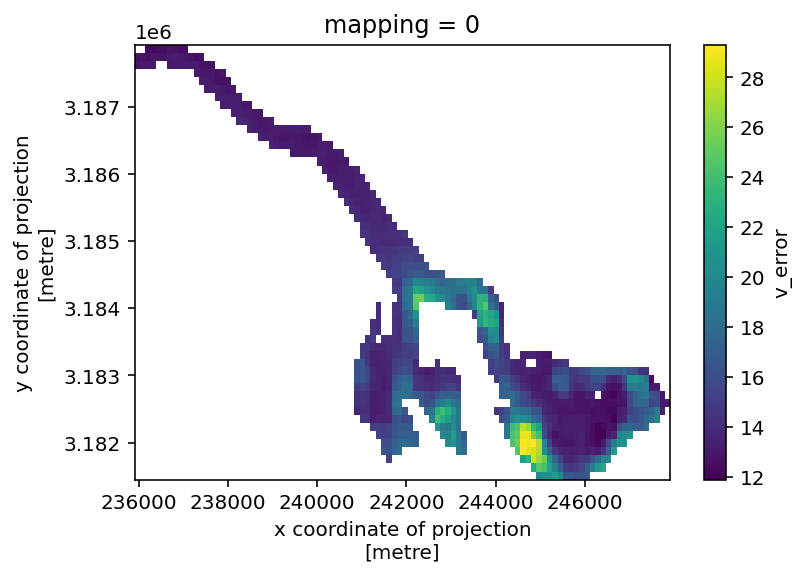

In [23]:
sample_glacier_raster.v_error.mean(dim=['mid_date']).plot();

## Exploring ITS_LIVE data

ITS_LIVE data cubes come with many (53!) variables that carry information about the estimated surface velocities and the satellite images that were used to generate the surface velocity estimates. We won't examine all of this information here but let's look at a litte bit.

To start with, let's look at the satellite imagery used to generate the velocity data.

We see that we have two `data_vars` that indicate which sensor that each image in the image pair at a certain time step comes from:

In [24]:
sample_glacier_raster.satellite_img1.data.compute()

array(['8.', '8.', '8.', ..., '2A', '2B', '2B'], dtype='<U2')

In [25]:
sample_glacier_raster.satellite_img2

<xarray.DataArray 'satellite_img2' (mid_date: 20549)>
dask.array<copy, shape=(20549,), dtype=<U2, chunksize=(20549,), chunktype=numpy.ndarray>
Coordinates:
    mapping   int64 0
  * mid_date  (mid_date) datetime64[ns] 2013-04-09T16:49:00.528084992 ... 202...
Attributes:
    description:    id of the satellite that acquired image 2
    standard_name:  image2_satellite

The `satellite_img1` and `satellite_img2` variables are 1-dimensional numpy arrays corresponding to the length of the `mid_date` dimension of the data cube. You can see that each element of the array is a string corresponding to a different satellite:
    `1A` = Sentinel 1A, `1B` = Sentinel 1B, `2A` = Sentinel 2A
    `2B` = Sentinel 2B, `8.` = Landsat8 and `9.` = Landsat9
    
Let's re-arrange these string arrays into a format that is easier to work with.

First, we'll make a set of all the different string values in the satellite image variables:

## Examining velocity data from each satellite in `ITS_LIVE` dataset

What if we only wanted to look at the velocity estimates from landat8?

In [26]:
l8_data = sample_glacier_raster.where(sample_glacier_raster['satellite_img1'] == '8.', drop=True)
l8_data

<xarray.Dataset>
Dimensions:                    (mid_date: 7257, y: 54, x: 100)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2013-04-09T16:49:00....
  * y                          (y) float64 3.188e+06 3.188e+06 ... 3.182e+06
  * x                          (x) float64 2.36e+05 2.361e+05 ... 2.479e+05
Data variables: (12/53)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(7257,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(7257,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) object dask.array<chunksize=(7257,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(7257, 20, 21), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(7257, 20, 21), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(7257,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

`dataset.where()` at first seems appropriate to use for kind of operation but there's actually an easier way. Because we are selecting along a single dimension (`mid_date`), we can use xarray's `.sel()` method instead. This is more efficient and integrates with `dask` arrays more smoothly.

In [27]:
l8_condition = sample_glacier_raster.satellite_img1.isin('8.')
l8_subset = sample_glacier_raster.sel(mid_date=l8_condition)
l8_subset

<xarray.Dataset>
Dimensions:                    (mid_date: 7257, y: 54, x: 100)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2013-04-09T16:49:00....
  * y                          (y) float64 3.188e+06 3.188e+06 ... 3.182e+06
  * x                          (x) float64 2.36e+05 2.361e+05 ... 2.479e+05
Data variables: (12/53)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(7257,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(7257,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(7257,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(7257, 20, 21), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(7257, 20, 21), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(7257,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(7257,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

We can see that we are looking at roughly a third of the original time steps. Let's take a look at the average speeds of the Landsat8-derived velocities:

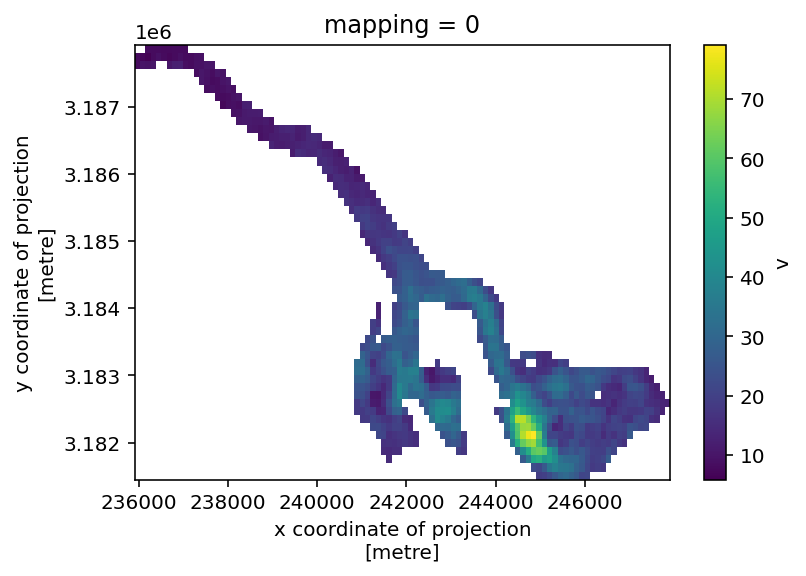

In [28]:
l8_subset.v.mean(dim='mid_date').plot();

What about Landsat9?

In [29]:
l9_condition = sample_glacier_raster.satellite_img1.isin('9.')

l9_subset = sample_glacier_raster.sel(mid_date=l9_condition)
l9_subset

<xarray.Dataset>
Dimensions:                    (mid_date: 46, y: 54, x: 100)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2021-11-06T16:48:19....
  * y                          (y) float64 3.188e+06 3.188e+06 ... 3.182e+06
  * x                          (x) float64 2.36e+05 2.361e+05 ... 2.479e+05
Data variables: (12/53)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(46,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(46,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(46,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(46, 20, 21), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(46, 20, 21), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(46,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(46,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Only 45 time steps have data from Landsat9, this makes sense because Landsat9 was just launched recently

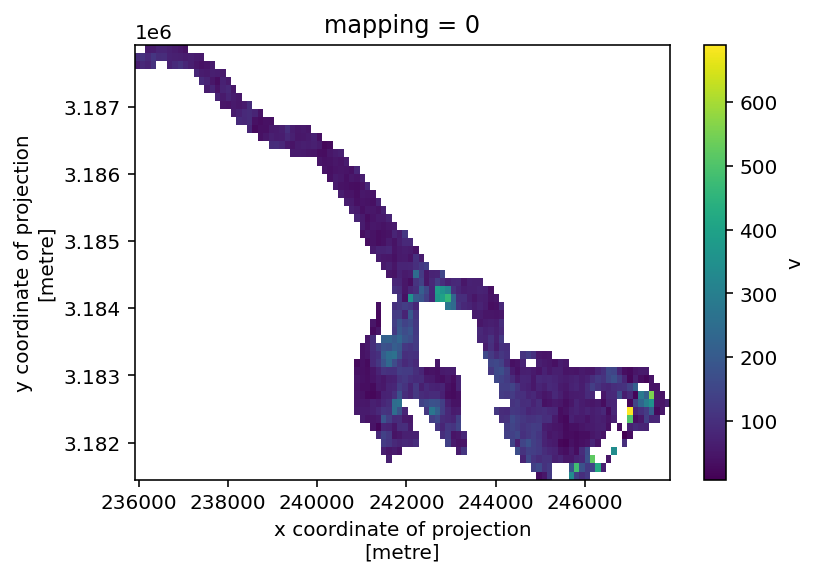

In [30]:
l9_subset.v.mean(dim='mid_date').plot();

Let's look at Sentinel 1 data. Note here we are selecting for 2 values instead of 1: 

In [31]:
s1_condition = sample_glacier_raster.satellite_img1.isin(['1A','1B'])
s1_subset = sample_glacier_raster.sel(mid_date = s1_condition)
s1_subset

<xarray.Dataset>
Dimensions:                    (mid_date: 475, y: 54, x: 100)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2014-10-13T00:19:06....
  * y                          (y) float64 3.188e+06 3.188e+06 ... 3.182e+06
  * x                          (x) float64 2.36e+05 2.361e+05 ... 2.479e+05
Data variables: (12/53)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(475,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(475,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(475,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(475, 20, 21), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(475, 20, 21), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(475,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(475,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(475,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(475,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(475,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(475,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(475,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

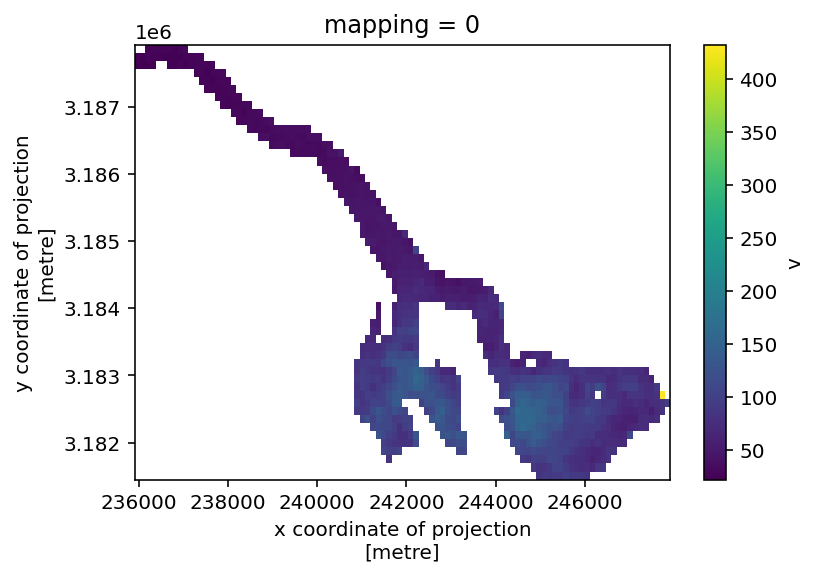

In [32]:
s1_subset.v.mean(dim='mid_date').plot();

In [33]:
s2_condition = sample_glacier_raster.satellite_img1.isin(['2A','2B'])
s2_subset = sample_glacier_raster.sel(mid_date=s2_condition)
s2_subset

<xarray.Dataset>
Dimensions:                    (mid_date: 12771, y: 54, x: 100)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2016-02-26T05:07:11....
  * y                          (y) float64 3.188e+06 3.188e+06 ... 3.182e+06
  * x                          (x) float64 2.36e+05 2.361e+05 ... 2.479e+05
Data variables: (12/53)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(12771,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(12771,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(12771,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(12771, 20, 21), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(12771, 20, 21), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(12771,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(12771,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(12771,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(12771,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(12771,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(12771,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(12771,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:14:40
    date_updated:               09-Jun-2022 04:14:40
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

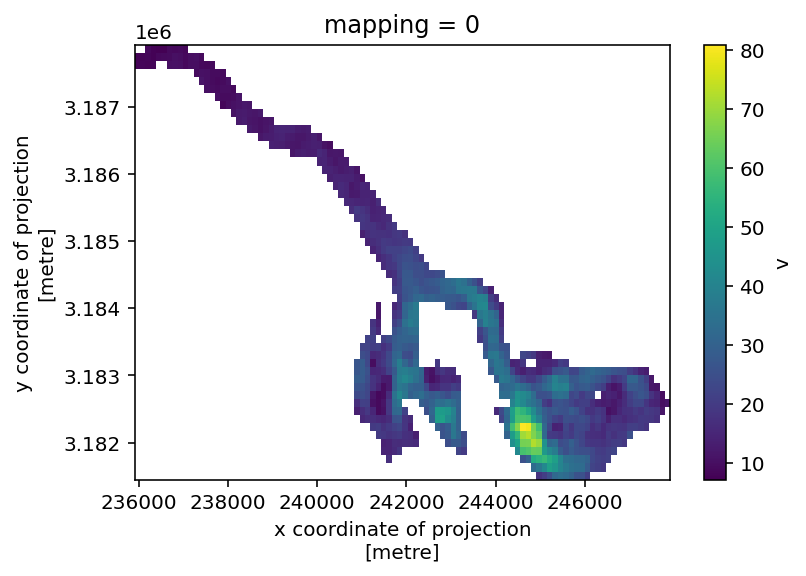

In [34]:
s2_subset.v.mean(dim='mid_date').plot();

## Checking coverage along a dimension
It would be nice to be able to scan/visualize and observe coverage of a variable along a dimension

First need to make a mask that will tell us all the possible 'valid' pixels. ie pixels over ice v. rock.

In [37]:
valid_pixels = sample_glacier_raster.v.count(dim=['x','y']).compute()
valid_pix_max = valid_pixels.max().data

cov = valid_pixels/valid_pix_max

sample_glacier_raster['cov'] = cov

```{note}
Still need to figure out the duplicate time step question...
```

In [38]:
#how many time steps are duplicates?, there are 16872 unique vals in mid_dates
np.unique(sample_glacier_raster['mid_date'].data).shape

(16872,)

Let's take a look at the data coverage over this glacier across the time series

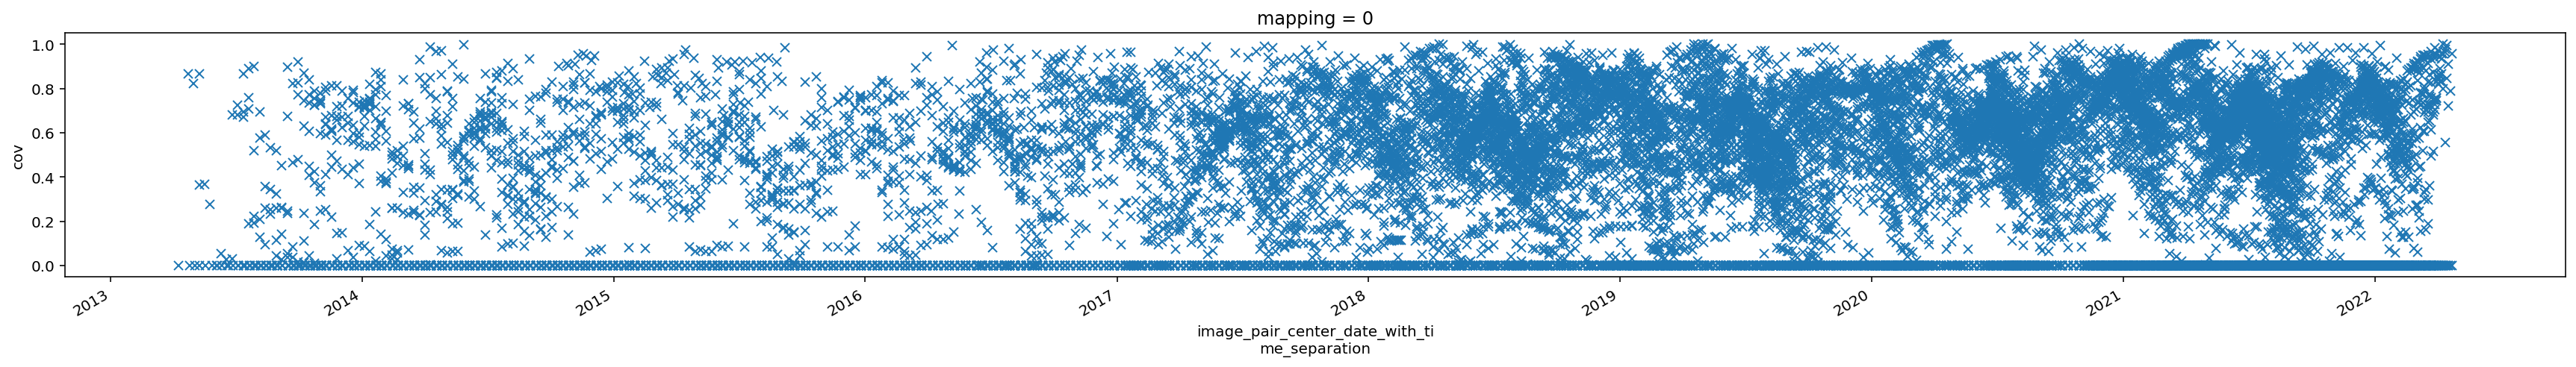

In [39]:
fig, ax = plt.subplots(figsize=(30,3))
sample_glacier_raster.cov.plot(ax=ax, linestyle='None',marker = 'x')

But what if we wanted to explore the relative coverage of the different sensors that make up the its_live dataset as a whole?
We can use `groupby` to group the data based on a single condition such as `satellite_img1` or `mid_date`.

In [41]:
sample_glacier_raster.cov.groupby(sample_glacier_raster.satellite_img1)

DataArrayGroupBy, grouped over 'satellite_img1'
6 groups with labels '1A', '1B', '2A', '2B', '8.', '9.'.

In [42]:
sample_glacier_raster.groupby('mid_date')

DatasetGroupBy, grouped over 'mid_date'
16872 groups with labels 2013-04-09T16:49:00.5280849....

However, if we want to examine the coverage of data from different sensor groups over time, we would essentially want to `groupby` two groups. To do this, we use `flox`

In [43]:
import flox.xarray

This is the `xr.DataArray` on which we will perform the grouping operation using `flox`

In [44]:
sample_glacier_raster.cov

<xarray.DataArray 'cov' (mid_date: 20549)>
array([0.        , 0.8654661 , 0.        , ..., 0.78813559, 0.        ,
       0.95868644])
Coordinates:
    mapping   int64 0
  * mid_date  (mid_date) datetime64[ns] 2013-04-09T16:49:00.528084992 ... 202...

Using `flox`, we will define a coverage object that takes as inputs the data we want to reduce, the groups we want to use to group the data and the reduction we want to perform. 

In [45]:
coverage = flox.xarray.xarray_reduce(
    sample_glacier_raster.cov,
    sample_glacier_raster.satellite_img1.compute(),
    sample_glacier_raster.mid_date,
    func="mean",
    fill_value=0,
)

/Users/emarshall/miniconda3/envs/itslivetools_env/lib/python3.10/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in true_divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


Now we can visualie the coverage over time for each sensor in the its_live dataset. Cool!

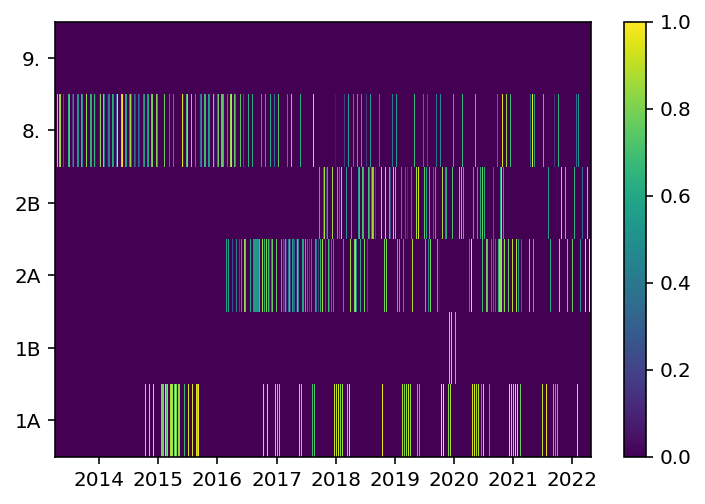

In [47]:
plt.pcolormesh(coverage.mid_date, coverage.satellite_img1, coverage, cmap='viridis')
plt.colorbar()

This notebook displayed basic data inspection steps that you can take when working with a new dataset. The following notebooks will demonstrate further processing, analytical and visualization steps you can take. 

## Seasonal mean velocities for each year with groupby

In [ ]:
year_gb = sample_glacier_raster.groupby(sample_glacier_raster.mid_date.dt.year)
year_gb

In [ ]:
yr_season_mean_v = flox.xarray.xarray_reduce(
    sample_glacier_raster.v,
    sample_glacier_raster.mid_date.dt.year,
    sample_glacier_raster.mid_date.dt.season,
    func = 'mean',
)

In [ ]:
fg_yr = yr_season_mean_v.plot(
        col='season',
        row = 'year',)